In [68]:
!pip install tensorflow

In [69]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
from keras.preprocessing import image

In [70]:
tf.__version__

'2.18.0'

In [71]:
%load_ext tensorboard
logdir = 'log'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [72]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

train_images, test_images = train_images / 255.0, test_images / 255.0

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [73]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [74]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [75]:
model.fit(x= train_images,
          y = train_labels,
          epochs=5,
          validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - accuracy: 0.8908 - loss: 0.3505 - val_accuracy: 0.9872 - val_loss: 0.0375
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 73s 34ms/step - accuracy: 0.9861 - loss: 0.0458 - val_accuracy: 0.9859 - val_loss: 0.0461
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 77s 31ms/step - accuracy: 0.9891 - loss: 0.0335 - val_accuracy: 0.9905 - val_loss: 0.0301
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 33ms/step - accuracy: 0.9920 - loss: 0.0235 - val_accuracy: 0.9893 - val_loss: 0.0288
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 62s 33ms/step - accuracy: 0.9936 - loss: 0.0197 - val_accuracy: 0.9911 - val_loss: 0.0262


In [76]:
y_true = test_labels
y_pred = np.argmax(model.predict(test_images), axis=-1)
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


In [77]:
con_mat = tf.math.confusion_matrix(labels = y_true, predictions = y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes,
                          columns = classes)


In [104]:
def sensibilidade(VP, FN):
  dicionario = {}
  for i in range(len(VP)):
    sensibilidade = VP[i] / (VP[i] + FN[i])
    dicionario[i] = sensibilidade
  return dicionario

def especifidade(VN, FP):
  dicionario = {}
  for i in range(len(VN)):
    especificidade = VN[i] / (VN[i] + FP[i])
    dicionario[i] = especificidade
  return dicionario

def acuracia(VP, VN, FP, FN):
  dicionario = {}
  for i in range(len(VP)):
    acuracia = (VP[i] + VN[i]) / (VP[i] + VN[i] + FP[i] + FN[i])
    dicionario[i] = acuracia
  return dicionario

def precisao(VP, FP):
  dicionario = {}
  for i in range(len(VP)):
    precisao = VP[i] / (VP[i] + FP[i])
    dicionario[i] = precisao
  return dicionario

def f1_score(precisao, sensibilidade):
    dicionario = {}
    for i in range(len(precisao)):
        if precisao[i] + sensibilidade[i] == 0:
            f1 = 0  # Evita divisão por zero
        else:
            f1 = 2 * (precisao[i] * sensibilidade[i]) / (precisao[i] + sensibilidade[i])
        dicionario[i] = f1
    return dicionario



In [105]:
tamanho_matrix = len(con_mat)

#Falsos Positivos (FP): Soma de todos os valores na coluna da classe específica, exceto o valor da diagonal principal (verdadeiros positivos).
#Falsos Negativos (FN): Soma de todos os valores na linha da classe específica, exceto o valor da diagonal principal (verdadeiros positivos).
#Verdadeiros Negativos (TN): Soma de todos os valores que não estão na linha nem na coluna da classe específica.
#Verdadeiros Positivos (TP): Valores que constam na diagonal da matriz de confusão

verdadeiro_positivo = []
falso_positivo = []
verdadeiro_negativo = []
falso_negativo = []

con_mat_df2 = pd.DataFrame(con_mat,
                          index = classes,
                          columns = classes)

verdadeiro_positivo = con_mat_df2.values.diagonal()
falso_positivo = con_mat_df2.sum(axis=0) - verdadeiro_positivo
falso_negativo = con_mat_df2.sum(axis=1) - verdadeiro_positivo
verdadeiro_negativo = [total - (verdadeiro_positivo[i] + falso_positivo[i] + falso_negativo[i]) for i in range(tamanho_matrix)]


sensi_variable = sensibilidade(verdadeiro_positivo, falso_negativo)
espec_variable = especifidade(verdadeiro_negativo, falso_positivo)
acur_variable = acuracia(verdadeiro_positivo, verdadeiro_negativo, falso_positivo, falso_negativo)
preci_variable = precisao(verdadeiro_positivo, falso_positivo)
f1_variable = f1_score(preci_variable, sensi_variable)

df_metricas = pd.DataFrame({
    "Classe": list(sensi_variable.keys()),
    "Sensibilidade (Recall)": list(sensi_variable.values()),
    "Especificidade": list(espec_variable.values()),
    "Acurácia": list(acur_variable.values()),
    "Precisão": list(preci_variable.values()),
    "F1-Score": list(f1_variable.values())
})

df_metricas.head(10)

,Classe,Sensibilidade (Recall),Especificidade,Acurácia,Precisão,F1-Score
0,0,0.997959,0.998559,0.9985,0.986882,0.992390
1,1,0.992070,0.999436,0.9986,0.995579,0.993822
2,2,0.994186,0.999665,0.9991,0.997085,0.995633
3,3,0.993069,0.999110,0.9985,0.992087,0.992578
4,4,0.989817,0.999335,0.9984,0.993865,0.991837
5,5,0.989910,0.999231,0.9984,0.992135,0.991021
6,6,0.989562,0.999005,0.9981,0.990596,0.990078
7,7,0.992218,0.998105,0.9975,0.983607,0.987893
8,8,0.991786,0.999003,0.9983,0.990769,0.991278
9,9,0.980178,0.998665,0.9968,0.988012,0.984080


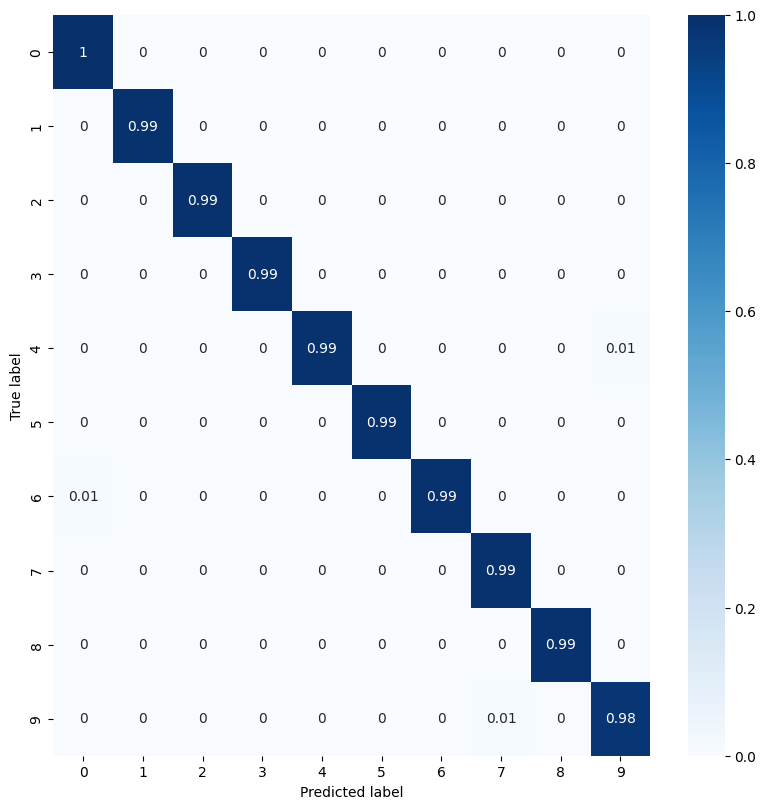

In [81]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()